- [빅쿼리 공식문서: Python 라이브러리](https://cloud.google.com/bigquery/docs/python-libraries?hl=ko#features_not_supported_by_pandas-gbq)

In [165]:
# %pip install google-cloud-bigquery

### 라이브러리 import

In [166]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./config/*.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials=credentials, project=credentials.project_id)


import warnings

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

In [167]:
# sql = f"""
# WITH session_list AS (
#   -- 전체 세션 리스트 
#   SELECT
#     EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS event_date,
#     TIMESTAMP_MICROS(event_timestamp) AS event_datetime,
#     user_pseudo_id,
#     user_id,
#     event_name, 
#     MAX(IF(params.key='firebase_screen', params.value.string_value, NULL)) AS `firebase_screen`, 
#     MAX(IF(params.key='session_id', params.value.string_value, NULL)) AS `session_id`, 
#     -- platform,
#   FROM advanced.app_logs
#   CROSS JOIN UNNEST(event_params) AS params
#   GROUP BY ALL
# )
# , order_logs AS (
#   -- 주문 로그
#   SELECT *
#   FROM session_list
#   WHERE event_name = 'click_payment'
# )
# , logs_never_ordered_before AS (
#   -- 주문 내역 없는 유저의 로그
#   SELECT
#     *
#   FROM session_list
#   WHERE 1=1
#   AND user_pseudo_id NOT IN (
#     -- 주문 내역 있는 유저 리스트
#     SELECT DISTINCT user_pseudo_id
#     FROM order_logs
#   )
# )
# , logs_ordered_before AS (
#   -- 주문 내역 있는 유저의 로그
#   SELECT
#     *
#   FROM session_list
#   WHERE 1=1
#   AND user_pseudo_id IN (
#     -- 주문 내역 있는 유저 리스트
#     SELECT DISTINCT user_pseudo_id
#     FROM order_logs
#   )
# )

# -- 3. 주문 내역 있는 유저: cohort weekly retention
# -- 주문 내역 있는 유저 중에서도 유입주차별로 나눠서 봤을 때 특히나 지속적으로 사용하는 그룹이 있을까?
# -- 만약 그렇다면 그 유입 주차가 연휴 주차인가?

# -- 3) 사용자별 첫방문일, 방문일, 방문간격(주차)
# , week_diff_per_user AS (
#   SELECT
#     *,
#     DATE_DIFF(event_week, first_week, WEEK) AS week_diff
#   FROM (
#     -- 2) 사용자별 첫방문일, 방문일 리스트 추출
#     SELECT DISTINCT
#       user_pseudo_id,
#       DATE_TRUNC(MIN(event_date) OVER (PARTITION BY user_pseudo_id), WEEK(MONDAY)) AS first_week,
#       DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week
#     FROM logs_ordered_before
#     -- ORDER BY user_pseudo_id, event_week
#   )
#   -- ORDER BY user_pseudo_id, event_week
# )
# , week_retain AS (
#   -- 코호트별 주차별 사용자 수 카운팅
#   SELECT
#     first_week,
#     week_diff,
#     COUNT(DISTINCT user_pseudo_id) AS retain_users
#   FROM week_diff_per_user
#   GROUP BY first_week, week_diff
#   -- ORDER BY first_week, week_diff
# )
# , week_retain_first AS (
#   -- 코호트별 0주차 사용자 수 추출
#   SELECT first_week, retain_users
#   FROM week_retain
#   WHERE week_diff = 0
# ) 


# -- 주차별 코호트 리텐션 계산
# SELECT
#   f.first_week,
#   w.week_diff,
#   w.retain_users,
#   f.retain_users AS first_users,
#   ROUND(SAFE_DIVIDE(w.retain_users,f.retain_users)*100,3) AS retention_rate
# FROM week_retain w
# CROSS JOIN week_retain_first f
# WHERE f.first_week = w.first_week
# AND f.first_week != '2022-07-25' 
# ORDER BY w.first_week, week_diff
# """

# query_job = client.query(sql)
# df = query_job.to_dataframe()
# df.head()

In [168]:
# %pip install db-dtypes

In [169]:
# df.info()

In [170]:
# import pandas as pd

# # first_week 컬럼을 datetime 자료형으로 변경
# df['first_week'] = df['first_week'].astype('str')

# df['first_week'] = pd.to_datetime(df['first_week'])
# df['first_week'] = df['first_week'].dt.date

# df.info()

In [171]:
# df.head()

In [172]:
# # week_diff를 float로 변경
# df['week_diff'] = df['week_diff'].astype(float)

In [173]:
# df['first_week'].unique()

In [174]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly as ply
# import plotly.graph_objects as go

# # 주문 내역 있는 유저들의 주차별 코호트 리텐션 그래프
# # 각 코호트마다 그래프를 그릴 것이다.


# temp = df['first_week'].unique()[1]
# df_target = df.loc[df['first_week'] == temp]

# sns.lineplot(data=df_target, x='week_diff', y='retention_rate')

In [175]:
# import plotly.express as ex

# fig = ex.line(data_frame=df, x='week_diff', y='retention_rate', color='first_week')

# fig.show()

### 사용주기
#### stickiness: DAU/MAU
일간 방문자 대비 한 달 안에 재방문하는 비율이 얼마나 될까?

In [176]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, mau_list AS (
  -- 단순 MAU: 월별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    DATE_TRUNC(event_date, MONTH) AS event_month,
    COUNT(DISTINCT user_pseudo_id) AS mau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY DATE_TRUNC(event_date, MONTH)
  -- ORDER BY event_month
)

-- stickiness 계산: dau/mau
SELECT
  d.event_date,
  -- m.event_month,
  d.dau,
  m.mau,
  ROUND(SAFE_DIVIDE(d.dau, m.mau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY m.event_month) AS sum_of_dau,
FROM mau_list m
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, MONTH) = m.event_month
ORDER BY m.event_month, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_daumau = query_job.to_dataframe()
df_stickiness_daumau.head()

,event_date,dau,mau,stickiness,sum_of_dau
0,2022-08-01,154,7351,2.0950,7864
1,2022-08-02,157,7351,2.1358,7864
2,2022-08-03,174,7351,2.3670,7864
3,2022-08-04,162,7351,2.2038,7864
4,2022-08-05,170,7351,2.3126,7864


In [177]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['mau'],
                         name='mau'
))

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(title_text="MAU vs.DAU 월간 합계 비교 추이")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [178]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['stickiness'],
))

fig.update_layout(title_text="stickiness: DAU/MAU")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### stickiness: DAU/WAU
일간 방문자 대비 일주일 안에 재방문하는 비율이 얼마나 될까?

In [179]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, wau_list AS (
  -- 단순 WAU: 주차별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
  -- ORDER BY event_week
)

-- stickiness 계산: dau/wau
SELECT
  d.event_date,
  -- w.event_week,
  w.wau,
  d.dau,
  ROUND(SAFE_DIVIDE(d.dau, w.wau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY w.event_week) AS sum_of_dau,
FROM wau_list w
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, WEEK(MONDAY)) = w.event_week
ORDER BY w.event_week, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_dauwau = query_job.to_dataframe()
df_stickiness_dauwau.head()

,event_date,wau,dau,stickiness,sum_of_dau
0,2022-08-01,1181,154,13.0398,1190
1,2022-08-02,1181,157,13.2938,1190
2,2022-08-03,1181,174,14.7333,1190
3,2022-08-04,1181,162,13.7172,1190
4,2022-08-05,1181,170,14.3946,1190


In [180]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['wau'],
                         name='wau'
))

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(title_text="WAU vs.DAU 주간 합계 비교 추이")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [181]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['stickiness'],
))

fig.update_layout(title_text="stickiness: DAU/WAU")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### 유입일 이후 방문 간격 분포
사용자는 몇 일에 한 번 방문할까?

In [182]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    FIRST_VALUE(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS first_event_date,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)

, user_active_interval AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    IFNULL(DATE_DIFF(event_date, prev_event_date, DAY),0) AS day_diff
  FROM user_active_sequence
  ORDER BY user_pseudo_id, event_date
)

SELECT
  *
FROM user_active_interval
WHERE day_diff != 0
"""

query_job = client.query(sql)
df_visit_interval = query_job.to_dataframe()
df_visit_interval.head()

,user_pseudo_id,event_date,prev_event_date,day_diff
0,1001016485.1302650668,2022-09-26,2022-08-27,30
1,1001016485.1302650668,2022-11-02,2022-09-26,37
2,1001081079.2295351100,2022-10-06,2022-10-01,5
3,1001081079.2295351100,2022-12-16,2022-10-06,71
4,1001261584.8948661538,2023-01-09,2022-11-04,66


In [183]:
import numpy as np

# 사분위수 계산 (q1=12일, q2=27일, q3=50일)
q1, q2, q3 = np.percentile(df_visit_interval["day_diff"], [25, 50, 75])
q1, q2,q3 = int(q1), int(q2), int(q3)
print(q1, q2, q3)

12 27 50


In [184]:
# IQR 계산
iqr = q3 - q1

# Lower & Upper Fence 계산
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# 이상치가 아닌 min/max 값 찾기
non_outliers = df_visit_interval[(df_visit_interval["day_diff"] >= lower_fence) & (df_visit_interval["day_diff"] <= upper_fence)]
min_value = non_outliers["day_diff"].min()

if lower_fence < 0:
    lower_fence = min_value    

lower_fence, upper_fence = int(lower_fence), int(upper_fence)

print(lower_fence, upper_fence)

1 107


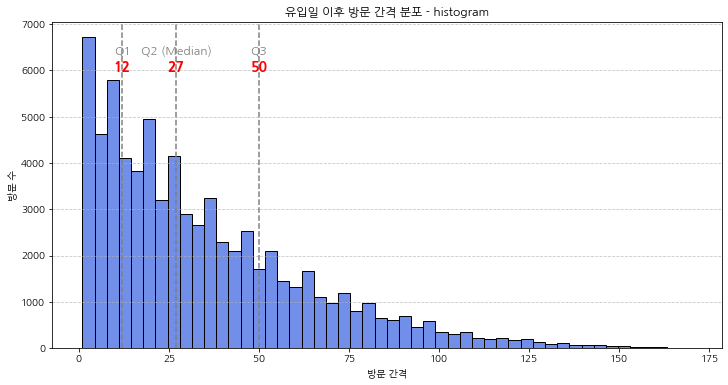

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')
%matplotlib inline

plt.figure(figsize=(12,6), facecolor='white')
sns.histplot(df_visit_interval['day_diff'], bins=50, color='royalblue')

# 사분위수
for q, label in zip([q1, q2, q3], ["Q1", "Q2 (Median)", "Q3"]):
    plt.axvline(q, color="gray", linestyle="dashed", linewidth=1.5)
    plt.text(q, plt.ylim()[1] * 0.9, label, color="gray", ha="center", fontsize=12)
    plt.text(q, plt.ylim()[1] * 0.85, q, color="red", ha="center", fontsize=14, fontweight="bold")


plt.xlabel("방문 간격")
plt.ylabel("방문 수")
plt.title("유입일 이후 방문 간격 분포 - histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 차트 출력
plt.show()

#### 주차별 리텐션
유입일 이후 주 단위로 봤을 때 얼마나 꾸준히 방문하는가?

In [186]:
sql = f"""
/* weekly range retention */

-- 2) 사용자별 첫방문일 기준 주 차이 계산
WITH week_diff_per_user AS (
  SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff
  FROM (
    -- 1) 사용자별 첫방문일, 방문일 리스트 추출
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_week) OVER(PARTITION BY user_pseudo_id) AS first_week,
      event_week
    FROM advanced.app_logs_cleaned_target
  )
)
, week_retain AS (
  -- 3) 주 차이별 이용자수 계산
  SELECT
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_user
  FROM week_diff_per_user
  GROUP BY week_diff
)

-- 5) 주 차이별 리텐션 비율 계산
, first_week_retain AS (
  SELECT
    COUNT(DISTINCT user_pseudo_id) AS first_week_retain_user
  FROM week_diff_per_user
  WHERE 1=1
  AND week_diff=0
)

SELECT
  week_.week_diff,
  week_.retain_user,
  first_week_.first_week_retain_user,
  ROUND(SAFE_DIVIDE(week_.retain_user, first_week_.first_week_retain_user)*100, 3) AS retention_ratio
FROM week_retain AS week_
CROSS JOIN first_week_retain AS first_week_
ORDER BY week_.week_diff ASC
"""

query_job = client.query(sql)
df_weekly_retention = query_job.to_dataframe()
df_weekly_retention.head()

,week_diff,retain_user,first_week_retain_user,retention_ratio
0,0,49678,49678,100.000
1,1,4375,49678,8.807
2,2,4599,49678,9.258
3,3,4673,49678,9.407
4,4,4545,49678,9.149


In [187]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_weekly_retention['week_diff'],
                         y=df_weekly_retention['retention_ratio'],
))

fig.update_layout(title_text="주차별 리텐션")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

### 사용 시간, 요일
#### 사용 시간대 분포

In [188]:
sql = f"""
-- 전체 유저 기준 주로 어느 시간대에 접속했는가?
SELECT
  EXTRACT(HOUR FROM event_time) AS event_hour,
  COUNT(DISTINCT user_pseudo_id) AS user_cnt
FROM advanced.app_logs_cleaned_target
GROUP BY event_hour
ORDER BY event_hour;
"""

query_job = client.query(sql)
df_visithour = query_job.to_dataframe()
df_visithour.head()

,event_hour,user_cnt
0,0,1069
1,1,1065
2,2,1066
3,3,1074
4,4,1058


In [189]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visithour['event_hour'],
                         y=df_visithour['user_cnt'],
))

fig.update_layout(title_text="시간대별 사용자 수 분포")
fig.update_xaxes(title_text='시간 (hour)')
fig.update_yaxes(title_text='사용자 수')

fig.show()

#### 사용 요일 + 시간대 분포

In [190]:
sql = f"""
-- 전체 유저 기준 주로 어느 요일+시간에 접속했는가?
SELECT DISTINCT
  FORMAT_DATETIME("%a %Hh", event_datetime) AS event_dow_hour,  -- 요일 + 시간 출력
  RANK() OVER (ORDER BY event_dow, event_hour) AS order_num,
  COUNT(DISTINCT user_pseudo_id) OVER (PARTITION BY event_dow, event_hour) AS user_cnt
FROM (
  SELECT
    event_datetime,
    event_dow,
    EXTRACT(HOUR FROM event_datetime) AS event_hour,
    user_pseudo_id
  FROM advanced.app_logs_cleaned_target
)
ORDER BY order_num
"""

query_job = client.query(sql)
df_visitdowhour = query_job.to_dataframe()
df_visitdowhour.head()

,event_dow_hour,order_num,user_cnt
0,Mon 00h,1,108
1,Mon 01h,749,110
2,Mon 02h,1409,109
3,Mon 03h,2118,106
4,Mon 04h,2786,108


In [191]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visitdowhour['event_dow_hour'],
                         y=df_visitdowhour['user_cnt'],
))

fig.update_layout(title_text="요일+시간대별 사용자 수 분포")
fig.update_xaxes(title_text="요일 + 시간")
fig.update_yaxes(title_text='사용자 수')

fig.show()

### 세션, 스크린뷰, 체류시간
#### 일별 유저당 평균 세션 수

In [192]:
sql = f"""
  -- 하루에 사용자들이 평균적으로 몇 번 방문하는가?
  -- 일별 유저당 평균 세션 수
  SELECT
    event_date,
    ROUND(AVG(session_cnt), 2) AS avg_sessions_per_user
  FROM (
    -- 일별 유저별 세션 수
    SELECT
      event_date,
      user_pseudo_id,
      COUNT(DISTINCT session_id) AS session_cnt,
    FROM `advanced.app_logs_cleaned_target`
    GROUP BY event_date, user_pseudo_id
  )
  GROUP BY event_date
  ORDER BY event_date
"""

query_job = client.query(sql)
df_sess_per_day_user = query_job.to_dataframe()
df_sess_per_day_user.head()

,event_date,avg_sessions_per_user
0,2022-08-01,1.0
1,2022-08-02,1.0
2,2022-08-03,1.0
3,2022-08-04,1.0
4,2022-08-05,1.0


In [193]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sess_per_day_user['event_date'],
                         y=df_sess_per_day_user['avg_sessions_per_user'],
))

fig.update_layout(title_text="일별 유저당 평균 세션 수 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='세션 수')

fig.show()

#### 일별 세션당 평균 스크린뷰

In [194]:
sql = f"""
-- 하루에 한 번 방문할 때 몇 개의 화면을 보는가?
-- 일별 세션당 평균 스크린뷰, 유니크뷰
SELECT
  event_date,
  ROUND(AVG(screen_view_cnt), 2) AS avg_screen_view_per_sess,
  ROUND(AVG(unique_view_cnt), 2) AS avg_unique_view_per_sess,
FROM (
  -- 일별 세션별 스크린뷰, 유니크뷰
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    COUNT(*) AS screen_view_cnt,
    COUNT(DISTINCT firebase_screen) AS unique_view_cnt,
  FROM `advanced.app_logs_cleaned_target`
  WHERE event_name='screen_view'
  GROUP BY event_date, user_pseudo_id, session_id
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_screenview_per_sess = query_job.to_dataframe()
df_screenview_per_sess.head()

,event_date,avg_screen_view_per_sess,avg_unique_view_per_sess
0,2022-08-01,3.06,3.05
1,2022-08-02,3.46,3.43
2,2022-08-03,3.27,3.25
3,2022-08-04,3.30,3.30
4,2022-08-05,3.18,3.16


In [195]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_screen_view_per_sess'],
                         name="screen view"
))

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_unique_view_per_sess'],
                         name="unique view"
))

fig.update_layout(title_text="일별 세션당 평균 스크린뷰 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='스크린뷰')

fig.show()

#### 일별 세션당 화면당 평균 체류시간

In [196]:
sql = f"""
-- 하루에 한 번 방문할 때 화면당 얼마나 머무르는가?
-- 일별 세션당 화면당 평균 체류시간 (firebase_screen별 체류시간)
SELECT
  event_date,
  ROUND(AVG(duration_time),2) AS avg_duration_time_per_screen,
FROM (
  -- 일별 세션당 화면당 체류시간
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    firebase_screen,
    DATETIME_DIFF(MAX(event_datetime), MIN(event_datetime), SECOND) AS duration_time,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date, user_pseudo_id, session_id, firebase_screen
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_duration_per_screen = query_job.to_dataframe()
df_duration_per_screen.head()

,event_date,avg_duration_time_per_screen
0,2022-08-01,10.99
1,2022-08-02,12.11
2,2022-08-03,11.63
3,2022-08-04,11.10
4,2022-08-05,10.80


In [197]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_duration_per_screen['event_date'],
                         y=df_duration_per_screen['avg_duration_time_per_screen'],
))

fig.update_layout(title_text="일별 세션당 화면당 평균 체류시간")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='체류시간 (초)')

fig.show()

### 주문
#### 일별 주문수 추이

In [198]:
sql = f"""
-- 일일 주문한 유저 수
SELECT
  event_date,
  COUNT(DISTINCT user_id) AS order_users_cnt
FROM advanced.app_logs_cleaned_target
WHERE event_name = 'click_payment'
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_order_user = query_job.to_dataframe()
df_order_user.head()

,event_date,order_users_cnt
0,2022-08-01,12
1,2022-08-02,21
2,2022-08-03,24
3,2022-08-04,12
4,2022-08-05,10


In [199]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_order_user['event_date'],
                         y=df_order_user['order_users_cnt'],
))

fig.update_layout(title_text="일별 주문 유저 수 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문한 사람 수')

fig.show()

#### DAU 대비 주문 유저 수 추이

In [200]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
  ORDER BY event_date
)

-- DAU와 일별 주문 유저 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM dau_list d
INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
df_order_ratio = query_job.to_dataframe()
df_order_ratio.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,154,12,7.792
1,2022-08-02,157,21,13.376
2,2022-08-03,174,24,13.793
3,2022-08-04,162,12,7.407
4,2022-08-05,170,10,5.882


In [201]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['dau'],
                         name="DAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(title_text="DAU 대비 주문 유저 수 추이")
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

#### WAU 대비 주문 유저 수 추이

In [202]:
sql = f"""
WITH wau_list AS (
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
)
, order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    event_week,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_week
)

-- WAU와 주간 주문 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  w.event_week,
  w.wau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM wau_list w
INNER JOIN order_cnt_list_w o ON w.event_week = o.event_week
ORDER BY w.event_week ASC

"""

query_job = client.query(sql)
df_order_ratio_w = query_job.to_dataframe()
df_order_ratio_w.head()

,event_week,wau,order_users_cnt,order_ratio
0,2022-08-01,1181,120,10.161
1,2022-08-08,1367,105,7.681
2,2022-08-15,1985,255,12.846
3,2022-08-22,2191,225,10.269
4,2022-08-29,2612,267,10.222


In [203]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio_w['event_week'],
                         y=df_order_ratio_w['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio_w['event_week'],
                         y=df_order_ratio_w['wau'],
                         name="WAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(title_text="WAU 대비 주문 유저 수 추이")
fig.update_xaxes(title_text="주차")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

### 유저 세분화
#### 재방문 주기 패턴

1. 유저 그룹 정의
- 일회성 유저: 재방문 없음.
- 단기 재방문자: 14일 이내 재방문.
- 중기 재방문자: 15~30일 이내 재방문.
- 장기 재방문자: 30일 초과 재방문.

2. 1에 대한 기준 설정  
- 각 유저별로 방문 간격 유형 카운팅 (단기 2번, 중기 2번, ..)
- 위에 대해 최빈 유형으로 해당 유저의 그룹을 정의함. (단기 2번, 중기 1번, 장기 0번 → 단기 재방문자 그룹)
- 최빈 유형이 다수인 경우, 최신 유형으로 유저의 그룹을 정의함. (단기 2번, 중기 2번, 장기 1번 / 최신 방문 주기가 '중기'에 해당함. → 중기 재방문자 그룹)

In [204]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
  -- 회원 49678명
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_only_1day AS (
  -- 2-1. 정합성 검증: 하루만 사용하고 이탈한 사람 13151명
  SELECT DISTINCT
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) = 1
  )
)
, user_visit_interval_calc AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
    ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
    CASE
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
      ELSE 'long'
    END AS visit_interval_cat,
  FROM user_active_sequence
  WHERE 1=1
  AND user_pseudo_id NOT IN (SELECT * FROM user_only_1day)  -- 재방문한 유저만 남김
  AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
  AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
)
, visit_interval_count_per_user AS (
  -- 3. 유저별 방문 간격 유형별 카운팅
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    COUNT(*) AS cnt,
  FROM user_visit_interval_calc
  GROUP BY user_pseudo_id, visit_interval_cat
)
, mode_visit_interval_cat_per_user AS (
  -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    cnt,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
  FROM visit_interval_count_per_user
  QUALIFY cat_cnt_order = 1
)

, result AS (
  -- 한번만 방문한 유저 (13151명)
  SELECT
    user_pseudo_id,
    'one_day' AS visit_interval_cat,
  FROM user_only_1day

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류 (26370명)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM mode_visit_interval_cat_per_user
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류 (10157명)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_visit_interval_calc
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )
  AND visit_interval_order = 1
)


SELECT
  COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS one_day_users,
  COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
--  COUNT(DISTINCT user_pseudo_id) AS tot_member_users,
FROM result
"""

query_job = client.query(sql)
df_visit_seg = query_job.to_dataframe()
df_visit_seg.head()

,one_day_users,short_term_users,mid_term_users,long_term_users
0,13151,9661,8517,18349


In [205]:
list(df_visit_seg.columns)

['one_day_users', 'short_term_users', 'mid_term_users', 'long_term_users']

In [206]:
list(df_visit_seg.values[0])

[13151, 9661, 8517, 18349]

In [207]:
fig = go.Figure()

fig.add_trace(go.Pie(labels=list(df_visit_seg.columns),
                     values=list(df_visit_seg.values[0]),
                     textinfo='value+percent'
))

fig.update_layout(title_text="회원 유저의 재방문 주기 구분")

fig.show()

### 주문 퍼널

#### 일회성 유저 vs. 재방문 유저: 전체 기간

In [208]:
sql = f"""
/* 주문 퍼널: 일회성 유저 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  -- 일회성 유저 전체 인원인 13151명, 분석 대상 로그 수 39114건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, one_day_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 39114건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM one_day_user_logs
)
, one_day_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM one_day_funnel_annot
)
, one_day_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM one_day_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 재방문 유저 */

, revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  -- 재방문 유저 전체 인원인 36527명, 분석 대상 로그 수 273441건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, revisit_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 273441건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM revisit_user_logs
)
, revisit_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM revisit_funnel_annot
)
, revisit_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM revisit_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'one_day' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM one_day_funnel_cnt
CROSS JOIN one_day_tot
-- ORDER BY funnel_step ASC

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'revisit' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM revisit_funnel_cnt
CROSS JOIN revisit_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_visit = query_job.to_dataframe()
df_order_funnel_visit.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,one_day,1,13151,13151,1.000
1,one_day,2,9763,13151,0.742
2,one_day,3,2539,13151,0.193
3,one_day,4,1616,13151,0.123
4,revisit,1,36527,36527,1.000


In [209]:
funnel_oneday = df_order_funnel_visit.loc[df_order_funnel_visit['user_segment']=='one_day']
funnel_revisit = df_order_funnel_visit.loc[df_order_funnel_visit['user_segment']=='revisit']


fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_oneday['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'one-day users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_revisit['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'revisit users',
    textinfo = 'value+percent initial'
))

fig.update_layout(
    title_text="주문 퍼널 전환율: 일회성 유저 vs. 재방문 유저",
    margin_l=10,
    margin_r=10,
    margin_b=50,
    margin_t=70
)


fig.show()

#### 통계적 검정: 그룹간 주문 횟수 차이 검정

- 위 결과에 의하면 수치적 차이(12.3% vs. 27%)가 존재하지만, 이것이 통계적으로 유의미한 차이인지 알아보기 위함.

##### 정규성 검정
- 모수 검정의 가정: 정규성 만족, 등분산성 만족
- 모수 검정 가능 여부를 알아보기 위해 정규성 검증을 진행한다.

In [210]:
sql = f"""
/* 주문 횟수: 일회성 vs. 재방문 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)


SELECT
  'one_day' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM one_day_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'revisit' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit = query_job.to_dataframe()
df_order_cnt_visit.head()

,user_segment,user_pseudo_id,order_cnt
0,revisit,2791809708.1121073842,3
1,revisit,6655662093.7330542838,3
2,revisit,3531266365.1404820251,3
3,revisit,4639663422.1398623523,3
4,revisit,7782549507.4642118070,3


In [211]:
import scipy.stats as stats

df_oneday_order_cnt = df_order_cnt_visit.loc[df_order_cnt_visit['user_segment']=='one_day', 'order_cnt']
df_revisit_order_cnt = df_order_cnt_visit.loc[df_order_cnt_visit['user_segment']=='revisit', 'order_cnt']

# 일회성 유저에 대한 주문 횟수 리스트 (모든 유저 0회 혹은 1회)
oneday_shapiro = stats.shapiro(df_oneday_order_cnt)

# 재방문 유저에 대한 주문 횟수 리스트
revisit_shapiro = stats.shapiro(df_revisit_order_cnt)

print(oneday_shapiro) 
print(revisit_shapiro)

ShapiroResult(statistic=0.3838534355163574, pvalue=0.0)
ShapiroResult(statistic=0.5888256430625916, pvalue=0.0)


- 검증 결과 p값이 0.05를 넘지 않으므로 정규성을 만족하지 못한다.
- 이에 따라 비모수 검정인 mann-whitney test 혹은 wilcoxon rank-sum test를 진행해야 한다.


##### Mann-Whitney U test

- 귀무가설: 일회성 유저와 재방문 유저 간의 평균 주문수 차이는 없다.
- 대립가설: 일회성 유저보다 재방문 유저의 평균 주문 수가 더 클 것이다.

In [212]:
from scipy.stats import mannwhitneyu

mannwhitneyu(df_oneday_order_cnt.astype(float), df_revisit_order_cnt.astype(float))

MannwhitneyuResult(statistic=203702582.0, pvalue=4.732275805405372e-273)

<!-- - 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 일회성 유저보다 재방문 유저의 평균 주문 수가 유의미하게 크다. -->

- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 재방문 유저의 주문 수가 유의미하게 더 크다.

#### 통계적 검정: 그룹간 주문율 차이 검정

- 위 결과에 의하면 수치적 차이(12.3% vs. 27%)가 존재하지만, 이것이 통계적으로 유의미한 차이인지 알아보기 위함.

##### 2 proportion z-test

- 귀무가설: 일회성 유저와 재방문 유저 간의 주문율 차이는 없다.
- 대립가설: 일회성 유저보다 재방문 유저의 주문율이 더 클 것이다.

In [213]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

count = np.array([
    funnel_oneday.loc[funnel_oneday['funnel_step']==4,'funnel_users'].values[0],
    funnel_revisit.loc[funnel_revisit['funnel_step']==4,'funnel_users'].values[0]
])


nobs = np.array([
    funnel_oneday['tot_users'].values[0],
    funnel_revisit['tot_users'].values[0]
])

proportions_ztest(count=count, nobs=nobs)

(-34.26151194263467, 2.9391033029695184e-257)

- 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 일회성 유저보다 재방문 유저의 주문율이 유의미하게 더 크다.

#### 단기 vs. 중기 vs. 장기: 전체 기간

In [214]:
sql = f"""
/* 주문 퍼널: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, short_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM short_user_logs
)
, short_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM short_funnel_annot
)
, short_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM short_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)

, mid_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM mid_user_logs
)
, mid_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM mid_funnel_annot
)
, mid_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM mid_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, long_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM long_user_logs
)
, long_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM long_funnel_annot
)
, long_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM long_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'short' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM short_funnel_cnt
CROSS JOIN short_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'mid' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM mid_funnel_cnt
CROSS JOIN mid_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'long' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM long_funnel_cnt
CROSS JOIN long_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_visit2 = query_job.to_dataframe()
df_order_funnel_visit2.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,long,1,18349,18349,1.000
1,long,2,16863,18349,0.919
2,long,3,6918,18349,0.377
3,long,4,4626,18349,0.252
4,mid,1,8517,8517,1.000


In [215]:
funnel_short = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='short']
funnel_mid = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='mid']
funnel_long = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_short['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'short-revisit users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_mid['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'mid-revisit users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_long['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'long-revisit users',
    textinfo = 'value+percent initial'
))

fig.update_layout(
    title_text="주문 퍼널 전환율: 단기 vs. 중기 vs. 장기",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.05,
    legend_x=0.98
)

fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정
##### 정규성 검정

In [216]:
sql = f"""
/* 주문 횟수: 단기 vs. 중기 vs. 장기 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)


SELECT
  'short' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM short_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'mid' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM mid_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'long' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM long_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit2 = query_job.to_dataframe()
df_order_cnt_visit2.head()

,user_segment,user_pseudo_id,order_cnt
0,short,7778741712.5165960558,2
1,short,2790945070.2066270888,1
2,short,9019561516.1964962195,1
3,short,1958726566.1171595411,1
4,short,6296256072.1508469282,0


In [217]:
import scipy.stats as stats

df_short_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='short', 'order_cnt']
df_mid_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='mid', 'order_cnt']
df_long_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='long', 'order_cnt']

short_shapiro = stats.shapiro(df_short_order_cnt)
mid_shapiro = stats.shapiro(df_mid_order_cnt)
long_shapiro = stats.shapiro(df_long_order_cnt)

print(short_shapiro)
print(mid_shapiro)
print(long_shapiro)

ShapiroResult(statistic=0.6139792203903198, pvalue=0.0)
ShapiroResult(statistic=0.5338236093521118, pvalue=0.0)
ShapiroResult(statistic=0.5289579033851624, pvalue=0.0)


- 검증 결과 p값이 0.05를 넘지 않으므로 정규성을 만족하지 못한다.
- 이에 따라 비모수 검정인 Kruskal-Wallis test를 진행해야 한다.


##### Kruskal-Wallis test

- 귀무가설: 단기, 중기, 장기 재방문 유저 간 주문 수 차이는 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저 간 주문 수 차이가 있다.

In [218]:
from scipy.stats import kruskal

kruskal(df_short_order_cnt, df_mid_order_cnt, df_long_order_cnt)

KruskalResult(statistic=300.6078723517424, pvalue=5.29456044154926e-66)

- 검정 결과 p-value가 0.05보다 더 작으므로 대립가설 채택.
- 즉, 세 그룹간 주문 수 차이가 유의미하다.

##### 사후검정: Dunn's test
- 세 그룹간 주문 수 차이의 '우위'를 파악하기 위해 사후검정 진행
- 다중 비교 오류
  - 총 3번의 pairwise 검정 발생 (단기vs.중기, 단기vs.장기, 중기vs.장기)
  - 각 검정의 유의수준을 0.05로 설정하면 전체 타입 오류 확률은 1-(1-0.05)^3 ~ 0.1426으로 증가
  - 따라서 이를 보정하기 위해 다양한 보정 방법을 적용해야 하며 bonferroni가 그 중 하나
  - bonferroni는 0.05/(비교횟수)로 유의수준 값을 조정해준다.


In [219]:
from scikit_posthocs import posthoc_dunn

df_dunn_visit = posthoc_dunn([df_short_order_cnt, df_mid_order_cnt, df_long_order_cnt], p_adjust='bonferroni')
df_dunn_visit.columns = ['short','mid','long']
df_dunn_visit.index = ['short','mid','long']
df_dunn_visit

,short,mid,long
short,1.000000e+00,9.783289e-60,5.043946e-60
mid,9.783289e-60,1.000000e+00,1.000000e+00
long,5.043946e-60,1.000000e+00,1.000000e+00


- 대각선(diagonal)을 기준으로 반쪽 삼각형만 확인하면 됨.  

- 단기 재방문 vs. 중기 재방문: p-value(=9.783289e-60) < 0.05 이므로 차이가 유의미함. (대립가설 채택)
- 단기 재방문 vs. 장기 재방문: p-value(=5.043946e-60) < 0.05 이므로 차이가 유의미함. (대립가설 채택)
- 중기 재방문 vs. 장기 재방문: p-value(=1) > 0.05 이므로 차이가 무의미함. (대립가설 기각)

- 결론: 중기, 장기 재방문 유저에 비해 단기 재방문 유저의 주문 수가 유의미하게 더 크다.


#### 통계적 검정: 그룹간 주문율 차이 검정

##### Chi-square test
- 귀무가설: 단기, 중기, 장기 재방문 유저간 주문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 주문율 차이가 있다.

In [220]:
from scipy.stats import chi2_contingency

# 단기, 중기, 장기 재방문 유저의 결제 인원
short_order_s = funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_s = funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_s = funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

# 단기, 중기, 장기 재방문 유저의 결제 안 한 인원
short_order_f = funnel_short['tot_users'].values[0] - funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_f = funnel_mid['tot_users'].values[0] - funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_f = funnel_long['tot_users'].values[0] - funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

observed= [
    [short_order_s,short_order_f],
    [mid_order_s,mid_order_f],
    [long_order_s,long_order_f] 
]

chi2, p, _, _ = chi2_contingency(observed=observed)
print(f"χ²: {chi2: .3f}, p-value: {p}")

χ²:  64.343, p-value: 1.0667768931877638e-14


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택
- 즉, 단기, 중기, 장기 재방문 유저간 주문율 차이가 유의미하다.

##### 사후검정: Bonferroni Correction
- 기존의 chi-square test를 pairwise하게 진행한다.
- bonferroni correction에 의해 유의수준은 0.05/3 = 0.0167이 된다.
- p-value가 0.0167보다 작은지 비교하면 된다.

In [221]:
from scipy.stats import chi2_contingency

# 단기 vs 중기
obs_short_mid = [[short_order_s, short_order_f], [mid_order_s, mid_order_f]]
chi2, p, _, _ = chi2_contingency(obs_short_mid)
print(f"short vs. mid: χ²={chi2:.3f}, p={p}")

# 단기 vs 장기 
obs_short_long = [[short_order_s, short_order_f], [long_order_s, long_order_f]]
chi2, p, _, _ = chi2_contingency(obs_short_long)
print(f"short vs. long: χ²={chi2:.3f}, p={p}")

# 중기 vs 장기
obs_mid_long = [[mid_order_s, mid_order_f], [long_order_s, long_order_f]]
chi2, p, _, _ = chi2_contingency(obs_mid_long)
print(f"mid vs. long: χ²={chi2:.3f}, p={p}")

short vs. mid: χ²=6.163, p=0.013047630961077064
short vs. long: χ²=60.125, p=8.901682862209445e-15
mid vs. long: χ²=20.894, p=4.854486692729251e-06


- 단기 재방문 vs. 중기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 단기 재방문 vs. 장기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 중기 재방문 vs. 장기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 결론: 단기, 중기, 장기 재방문 유저 간의 주문율 차이가 유의미하다.

### 리텐션
#### 단기 vs. 중기 vs. 장기: 전체 기간

In [222]:
sql = f"""
/* 단기, 중기, 장기 유저별 리텐션 계산 */

/* 주차별 리텐션: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 9661명, 분석 대상 로그 수 190787건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'short'
  )
)
, week_diff_short_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM short_user_logs
    )
)
, week_retain_short_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_short_users
    GROUP BY week_diff
)
, week0_retain_short_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_short_users
    WHERE week_diff = 0
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'mid'
  )
)
, week_diff_mid_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM mid_user_logs
    )
)
, week_retain_mid_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_mid_users
    GROUP BY week_diff
)
, week0_retain_mid_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_mid_users
    WHERE week_diff = 0
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'long'
  )
)
, week_diff_long_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM long_user_logs
    )
)
, week_retain_long_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_long_users
    GROUP BY week_diff
)
, week0_retain_long_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_long_users
    WHERE week_diff = 0
)


-- 주차별 리텐션 계산
SELECT
    'short' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_short_users w
CROSS JOIN week0_retain_short_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
    'mid' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_mid_users w
CROSS JOIN week0_retain_mid_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
    'long' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_long_users w
CROSS JOIN week0_retain_long_users f

ORDER BY user_segment, week_diff
"""

query_job = client.query(sql)
df_retention_w_visit_interval = query_job.to_dataframe()
df_retention_w_visit_interval.head()

,user_segment,week_diff,retain_users,first_users,retention_rate
0,long,0,18349,18349,100.000
1,long,1,1080,18349,5.886
2,long,2,1018,18349,5.548
3,long,3,933,18349,5.085
4,long,4,1239,18349,6.752


In [223]:
retention_w_short = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='short']
retention_w_mid = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='mid']
retention_w_long = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Scatter(x = retention_w_short['week_diff'],
                         y = retention_w_short['retention_rate'],
                         name = 'short_term users'
))

fig.add_trace(go.Scatter(x = retention_w_mid['week_diff'],
                         y = retention_w_mid['retention_rate'],
                         name = 'mid_term users'
))


fig.add_trace(go.Scatter(x = retention_w_long['week_diff'],
                         y = retention_w_long['retention_rate'],
                         name = 'long_term users'
))

fig.update_layout(
    title_text="방문 간격별 유저에 따른 주차별 리텐션",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

#### 통계적 검정: 그룹간 재방문율 차이

##### Friedman test 

- 귀무가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 있다.

In [224]:
from scipy.stats import friedmanchisquare

friedmanchisquare(
    retention_w_short['retention_rate'],
    retention_w_mid['retention_rate'],
    retention_w_long['retention_rate']
)

FriedmanchisquareResult(statistic=7.583333333333364, pvalue=0.022557973880055714)

- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 단기, 중기, 장기 재방문 유저 간의 리텐션 차이가 유의미하다.

### 코호트 리텐션

#### 재방문 유저 전체

In [225]:
sql = f"""
/* 재방문 유저의 코호트 리텐션 계산 */

WITH revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  -- 재방문 유저 전체 인원인 36527명, 분석 대상 로그 수 273441건
    SELECT
        event_datetime,
        event_date,
        event_time,
        event_week,
        event_dow,
        user_pseudo_id,
        user_id,
        firebase_screen,
        event_name,
        CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
        SELECT user_pseudo_id
        FROM advanced.app_logs_target_visit_seg
        WHERE visit_interval_cat = 'one_day'
    )
)
, week_diff_revisit AS (
    -- 2) 사용자별 유입주차, 방문주차, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_week) OVER (PARTITION BY user_pseudo_id) AS first_week,
        event_week,
    FROM revisit_user_logs
    )
)
, week_retain_revisit AS (
    -- 3) 유입주차, 방문간격(주차)별 유저 수 카운팅
    SELECT
        first_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_revisit
    GROUP BY first_week, week_diff
)


-- 코호트 리텐션 계산
SELECT
    first_week,
    week_diff,
    retain_users,
    first_users,
    SAFE_DIVIDE(retain_users,first_users) AS retention_rate
FROM (
    SELECT
        first_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY first_week ORDER BY week_diff) AS first_users
    FROM week_retain_revisit
)
"""

query_job = client.query(sql)
df_cohort_revisit = query_job.to_dataframe()
df_cohort_revisit.head()

,first_week,week_diff,retain_users,first_users,retention_rate
0,2022-08-01,0,1054,1054,1.000000
1,2022-08-01,1,32,1054,0.030361
2,2022-08-01,2,37,1054,0.035104
3,2022-08-01,3,59,1054,0.055977
4,2022-08-01,4,53,1054,0.050285


In [226]:
# 피봇 테이블 먼저 만들어주기
import pandas as pd

cohort_revisit_pivot = pd.pivot_table(
    data = df_cohort_revisit,
    index = 'first_week',
    columns = 'week_diff',
    values = 'retention_rate'
)

cohort_revisit_pivot

week_diff,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
first_week,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1.0,0.030361,0.035104,0.055977,0.050285,0.049336,0.075901,0.077799,0.063567,0.113852,...,0.110057,0.120493,0.116698,0.107211,0.123340,0.116698,0.097723,0.101518,0.113852,0.092979
2022-08-08,1.0,0.038363,0.050298,0.050298,0.057971,0.078431,0.072464,0.077579,0.090367,0.130435,...,0.134697,0.115090,0.131287,0.132140,0.112532,0.114237,0.103154,0.110827,0.075021,NaN
2022-08-15,1.0,0.038915,0.051887,0.050708,0.076651,0.054245,0.072524,0.096108,0.126179,0.117335,...,0.109670,0.140330,0.138561,0.121462,0.110849,0.112028,0.105542,0.068396,NaN,NaN
2022-08-22,1.0,0.054391,0.051558,0.061756,0.060623,0.082153,0.107649,0.130312,0.123513,0.118980,...,0.120113,0.145609,0.112181,0.116147,0.098584,0.117280,0.077054,NaN,NaN,NaN
2022-08-29,1.0,0.059889,0.072471,0.066935,0.082536,0.105687,0.139909,0.116759,0.113236,0.147962,...,0.141922,0.125818,0.125818,0.112229,0.123301,0.083040,NaN,NaN,NaN,NaN
2022-09-05,1.0,0.076628,0.069923,0.090517,0.100096,0.134579,0.126437,0.125958,0.128831,0.118295,...,0.105364,0.092433,0.115900,0.107759,0.085728,NaN,NaN,NaN,NaN,NaN
2022-09-12,1.0,0.067552,0.087075,0.119875,0.138618,0.123389,0.110894,0.140570,0.122608,0.118704,...,0.121437,0.106989,0.114408,0.079656,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-19,1.0,0.077025,0.098716,0.130589,0.111554,0.131917,0.133245,0.115981,0.124391,0.123506,...,0.110226,0.116866,0.082780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-26,1.0,0.102183,0.154148,0.128821,0.124454,0.142358,0.128821,0.121397,0.129694,0.125764,...,0.112227,0.086026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='week_diff', ylabel='first_week'>

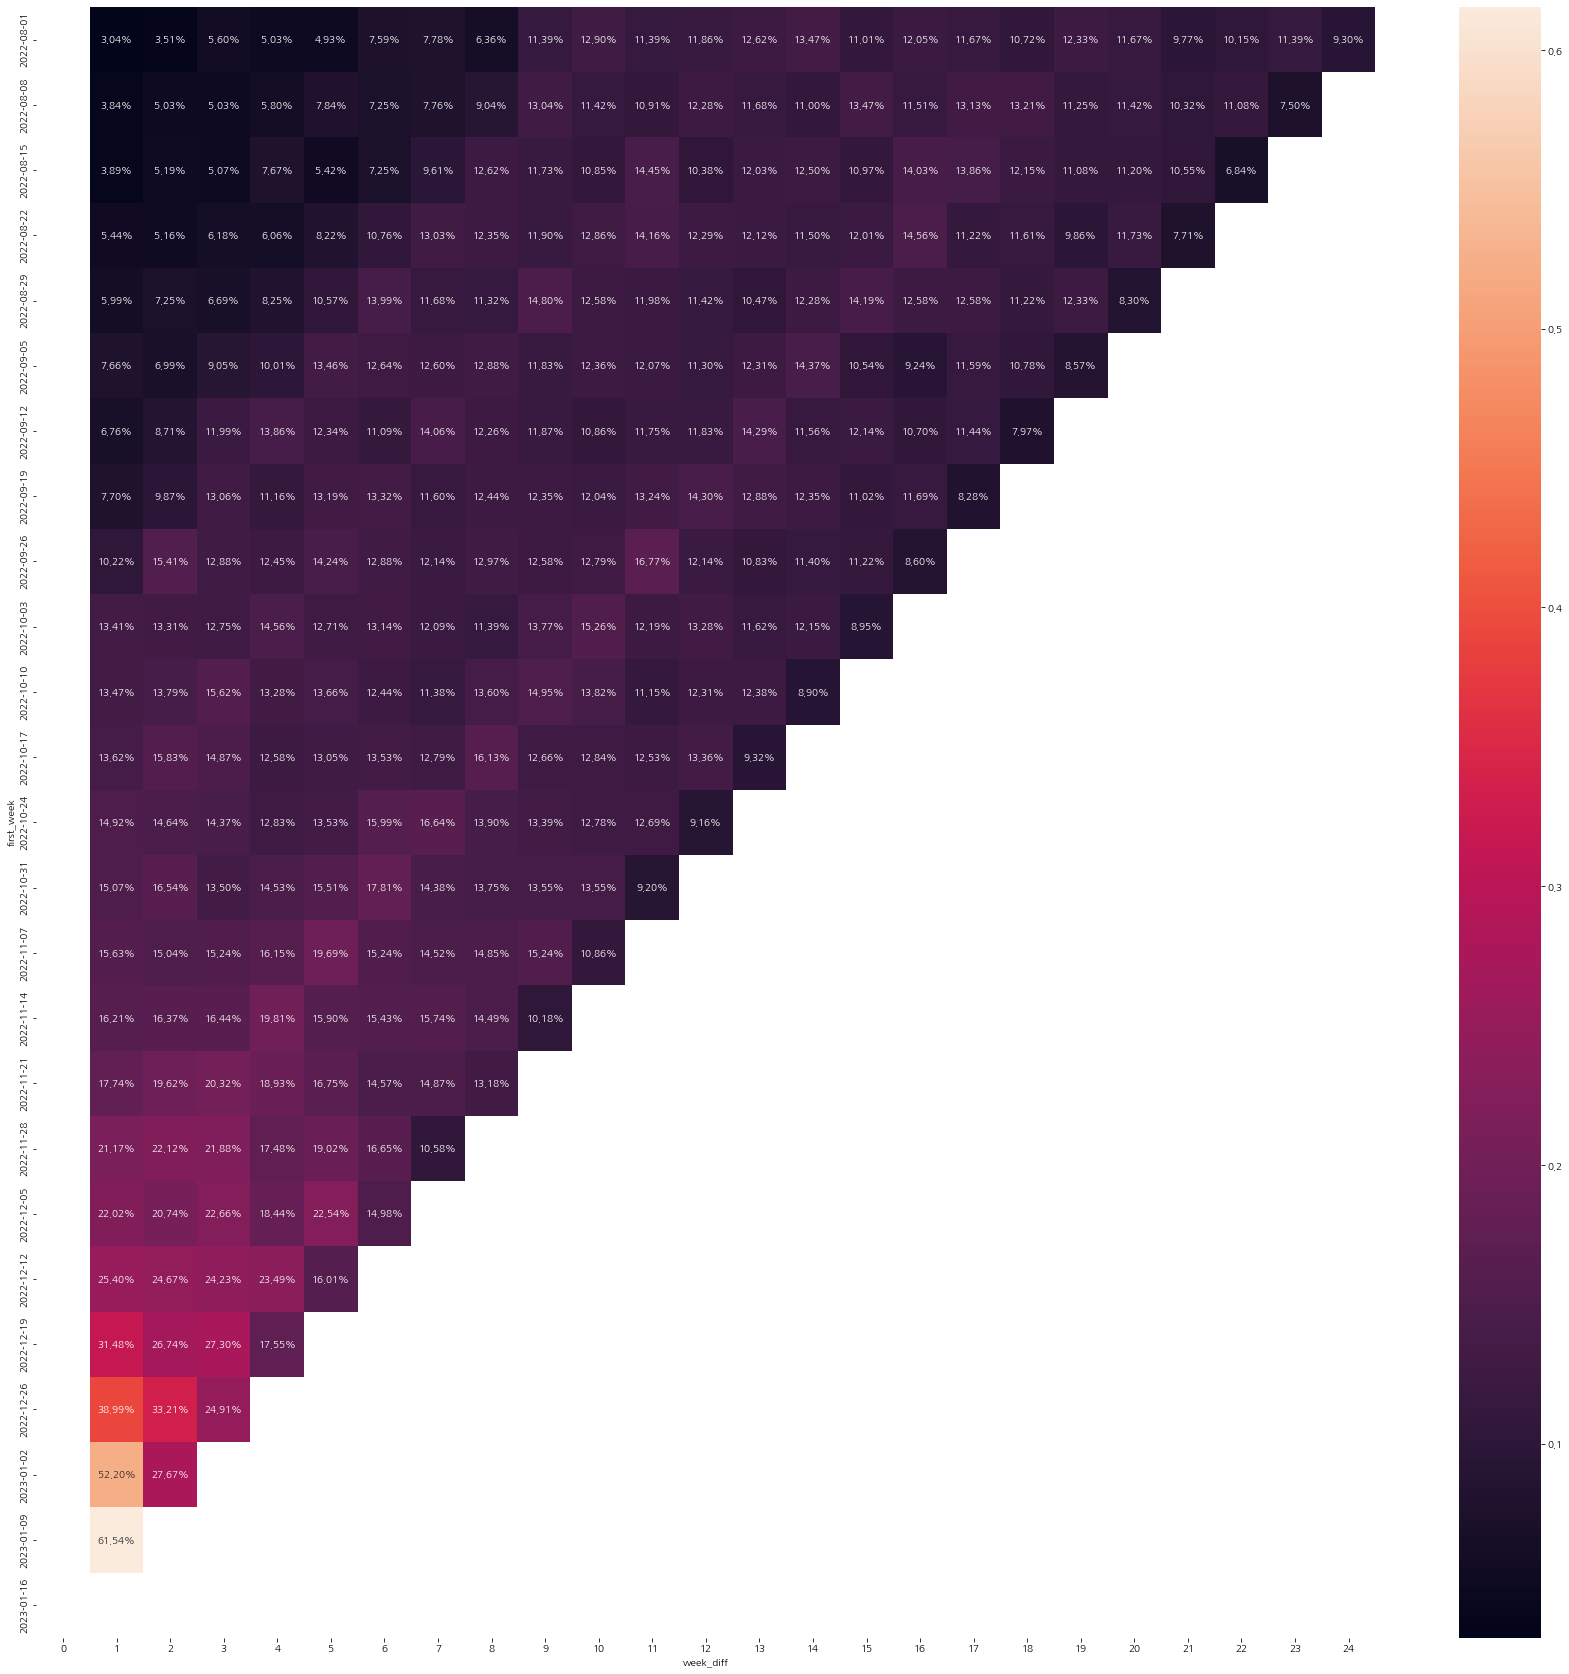

In [227]:
# 연휴 주차와 아닌 주차를 중심적으로 비교해보자

plt.figure(figsize=(30,30))

# 코호트 피봇 테이블에서 의미 없는 부분 (아래 절반 삼각형, 유입주차)
cohort_drop = cohort_revisit_pivot.isnull()
cohort_drop.iloc[:,0] = True

sns.heatmap(
    data = cohort_revisit_pivot,
    mask = cohort_drop,
    annot = True,
    fmt=".2%"
)

#### 단기 재방문 유저

In [240]:
sql = f"""
/* 단기 재방문 유저의 코호트 리텐션 계산 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 9661명, 분석 대상 로그 수 190787건
    SELECT
        event_datetime,
        event_date,
        event_time,
        event_week,
        event_dow,
        user_pseudo_id,
        user_id,
        firebase_screen,
        event_name,
        CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
        SELECT user_pseudo_id
        FROM advanced.app_logs_target_visit_seg
        WHERE visit_interval_cat = 'short'
    )
)
, week_diff_short AS (
    -- 2) 사용자별 유입주차, 방문주차, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_week) OVER (PARTITION BY user_pseudo_id) AS first_week,
        event_week,
    FROM short_user_logs
    )
)
, week_retain_short AS (
    -- 3) 유입주차, 방문간격(주차)별 유저 수 카운팅
    SELECT
        first_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_short
    GROUP BY first_week, week_diff
)


-- 코호트 리텐션 계산
SELECT
    first_week,
    week_diff,
    retain_users,
    first_users,
    SAFE_DIVIDE(retain_users,first_users) AS retention_rate
FROM (
    SELECT
        first_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY first_week ORDER BY week_diff) AS first_users
    FROM week_retain_short
)
"""

query_job = client.query(sql)
df_cohort_short = query_job.to_dataframe()
df_cohort_short.head()

,first_week,week_diff,retain_users,first_users,retention_rate
0,2022-08-01,0,161,161,1.000000
1,2022-08-01,1,12,161,0.074534
2,2022-08-01,2,8,161,0.049689
3,2022-08-01,3,15,161,0.093168
4,2022-08-01,4,10,161,0.062112


In [241]:
# 피봇 테이블 먼저 만들어주기
import pandas as pd

cohort_short_pivot = pd.pivot_table(
    data = df_cohort_short,
    index = 'first_week',
    columns = 'week_diff',
    values = 'retention_rate'
)

cohort_short_pivot

week_diff,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
first_week,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1.0,0.074534,0.049689,0.093168,0.062112,0.043478,0.074534,0.074534,0.074534,0.161491,...,0.198758,0.155280,0.142857,0.167702,0.186335,0.161491,0.130435,0.142857,0.086957,0.055901
2022-08-08,1.0,0.109756,0.103659,0.054878,0.042683,0.048780,0.054878,0.085366,0.073171,0.152439,...,0.140244,0.134146,0.219512,0.207317,0.164634,0.158537,0.134146,0.115854,0.048780,NaN
2022-08-15,1.0,0.101449,0.112319,0.039855,0.047101,0.032609,0.061594,0.072464,0.137681,0.137681,...,0.192029,0.159420,0.188406,0.177536,0.130435,0.137681,0.079710,0.054348,NaN,NaN
2022-08-22,1.0,0.118033,0.088525,0.088525,0.062295,0.075410,0.095082,0.095082,0.157377,0.147541,...,0.186885,0.200000,0.150820,0.150820,0.144262,0.091803,0.068852,NaN,NaN,NaN
2022-08-29,1.0,0.150838,0.134078,0.064246,0.086592,0.108939,0.134078,0.145251,0.145251,0.148045,...,0.187151,0.162011,0.164804,0.159218,0.120112,0.064246,NaN,NaN,NaN,NaN
2022-09-05,1.0,0.174129,0.146766,0.104478,0.104478,0.114428,0.124378,0.159204,0.129353,0.179104,...,0.119403,0.111940,0.104478,0.109453,0.059701,NaN,NaN,NaN,NaN,NaN
2022-09-12,1.0,0.147664,0.166355,0.119626,0.173832,0.151402,0.117757,0.155140,0.121495,0.138318,...,0.145794,0.134579,0.127103,0.059813,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-19,1.0,0.182590,0.182590,0.140127,0.127389,0.131635,0.118896,0.140127,0.142251,0.163482,...,0.138004,0.114650,0.076433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-26,1.0,0.179817,0.278899,0.168807,0.166972,0.144954,0.121101,0.135780,0.148624,0.146789,...,0.084404,0.051376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='week_diff', ylabel='first_week'>

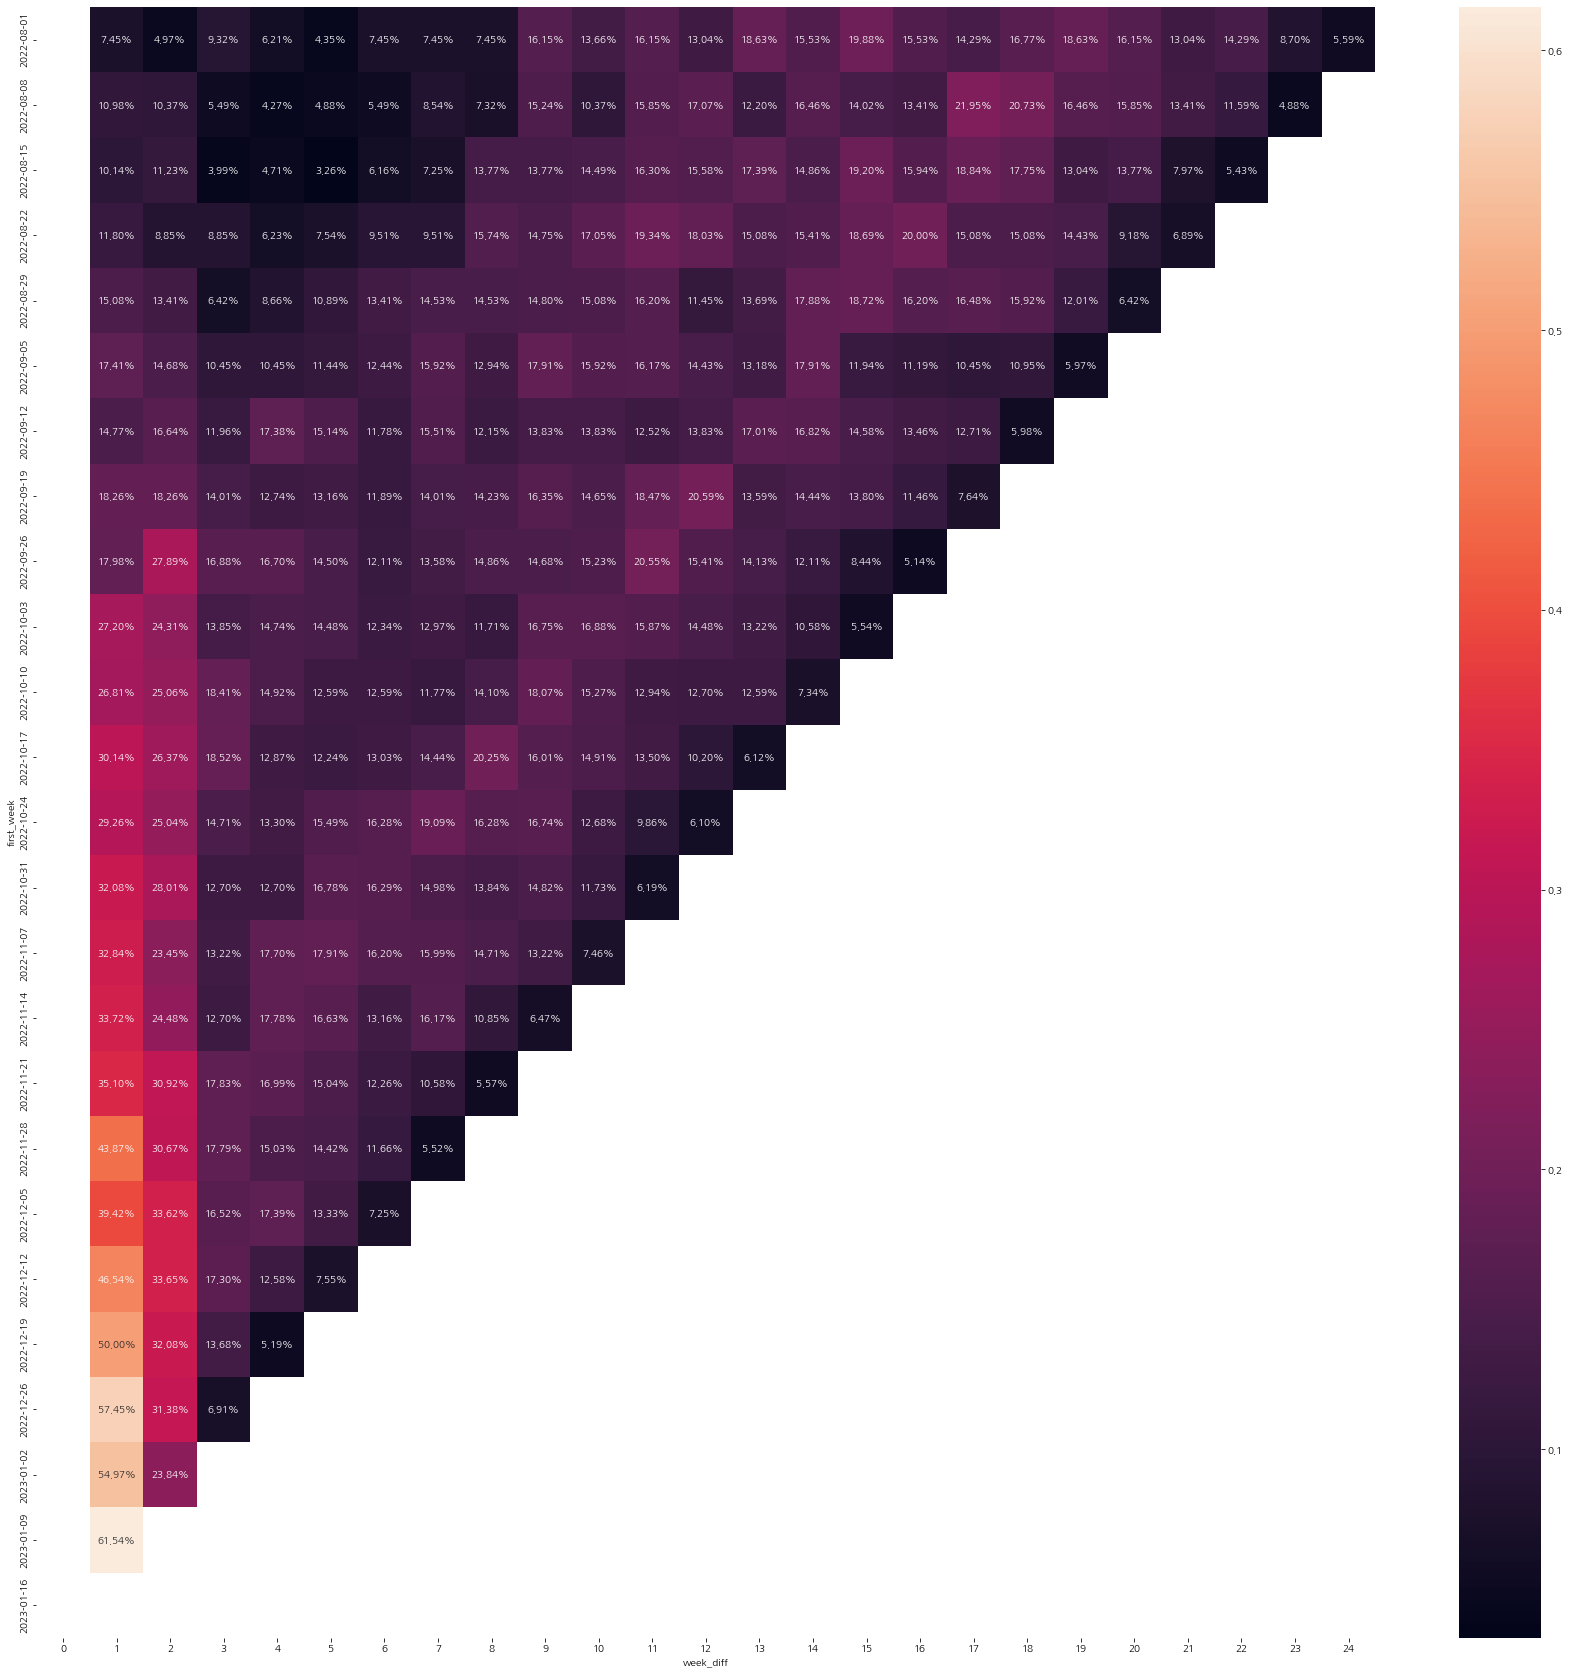

In [242]:
# 연휴 주차와 아닌 주차를 중심적으로 비교해보자

plt.figure(figsize=(30,30))

# 코호트 피봇 테이블에서 의미 없는 부분 (아래 절반 삼각형, 유입주차)
cohort_drop = cohort_short_pivot.isnull()
cohort_drop.iloc[:,0] = True

sns.heatmap(
    data = cohort_short_pivot,
    mask = cohort_drop,
    annot = True,
    fmt=".2%"
)

#### 중기 재방문 유저

In [243]:
sql = f"""
/* 중기 재방문 유저의 코호트 리텐션 계산 */

WITH mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
    SELECT
        event_datetime,
        event_date,
        event_time,
        event_week,
        event_dow,
        user_pseudo_id,
        user_id,
        firebase_screen,
        event_name,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
        SELECT user_pseudo_id
        FROM advanced.app_logs_target_visit_seg
        WHERE visit_interval_cat = 'mid'
    )
)
, week_diff_mid AS (
    -- 2) 사용자별 유입주차, 방문주차, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_week) OVER (PARTITION BY user_pseudo_id) AS first_week,
        event_week,
    FROM mid_user_logs
    )
)
, week_retain_mid AS (
    -- 3) 유입주차, 방문간격(주차)별 유저 수 카운팅
    SELECT
        first_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_mid
    GROUP BY first_week, week_diff
)


-- 코호트 리텐션 계산
SELECT
    first_week,
    week_diff,
    retain_users,
    first_users,
    SAFE_DIVIDE(retain_users,first_users) AS retention_rate
FROM (
    SELECT
        first_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY first_week ORDER BY week_diff) AS first_users
    FROM week_retain_mid
)
"""

query_job = client.query(sql)
df_cohort_mid = query_job.to_dataframe()
df_cohort_mid.head()

,first_week,week_diff,retain_users,first_users,retention_rate
0,2022-08-08,0,208,208,1.000000
1,2022-08-08,1,4,208,0.019231
2,2022-08-08,2,17,208,0.081731
3,2022-08-08,3,31,208,0.149038
4,2022-08-08,4,26,208,0.125000


In [244]:
# 피봇 테이블 먼저 만들어주기
import pandas as pd

cohort_mid_pivot = pd.pivot_table(
    data = df_cohort_mid,
    index = 'first_week',
    columns = 'week_diff',
    values = 'retention_rate'
)

cohort_mid_pivot

week_diff,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
first_week,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1.0,0.018987,0.056962,0.145570,0.120253,0.050633,0.075949,0.082278,0.075949,0.107595,...,0.145570,0.158228,0.170886,0.132911,0.151899,0.139241,0.101266,0.037975,0.113924,0.063291
2022-08-08,1.0,0.019231,0.081731,0.149038,0.125000,0.081731,0.086538,0.096154,0.129808,0.081731,...,0.211538,0.149038,0.192308,0.192308,0.129808,0.129808,0.115385,0.072115,0.052885,NaN
2022-08-15,1.0,0.016835,0.070707,0.111111,0.188552,0.063973,0.104377,0.090909,0.168350,0.117845,...,0.175084,0.195286,0.202020,0.164983,0.131313,0.090909,0.080808,0.060606,NaN,NaN
2022-08-22,1.0,0.037618,0.059561,0.150470,0.159875,0.072100,0.137931,0.172414,0.147335,0.156740,...,0.134796,0.216301,0.134796,0.112853,0.065831,0.097179,0.065831,NaN,NaN,NaN
2022-08-29,1.0,0.046961,0.099448,0.165746,0.171271,0.132597,0.171271,0.121547,0.138122,0.174033,...,0.185083,0.118785,0.121547,0.104972,0.096685,0.063536,NaN,NaN,NaN,NaN
2022-09-05,1.0,0.051852,0.079012,0.217284,0.207407,0.143210,0.160494,0.177778,0.175309,0.162963,...,0.118519,0.096296,0.088889,0.059259,0.064198,NaN,NaN,NaN,NaN,NaN
2022-09-12,1.0,0.042226,0.105566,0.259117,0.232246,0.105566,0.136276,0.178503,0.170825,0.134357,...,0.101727,0.065259,0.086372,0.061420,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-19,1.0,0.051331,0.121673,0.266160,0.209125,0.134981,0.165399,0.123574,0.169202,0.155894,...,0.083650,0.093156,0.043726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-26,1.0,0.088000,0.186000,0.256000,0.190000,0.160000,0.176000,0.140000,0.158000,0.154000,...,0.080000,0.054000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='week_diff', ylabel='first_week'>

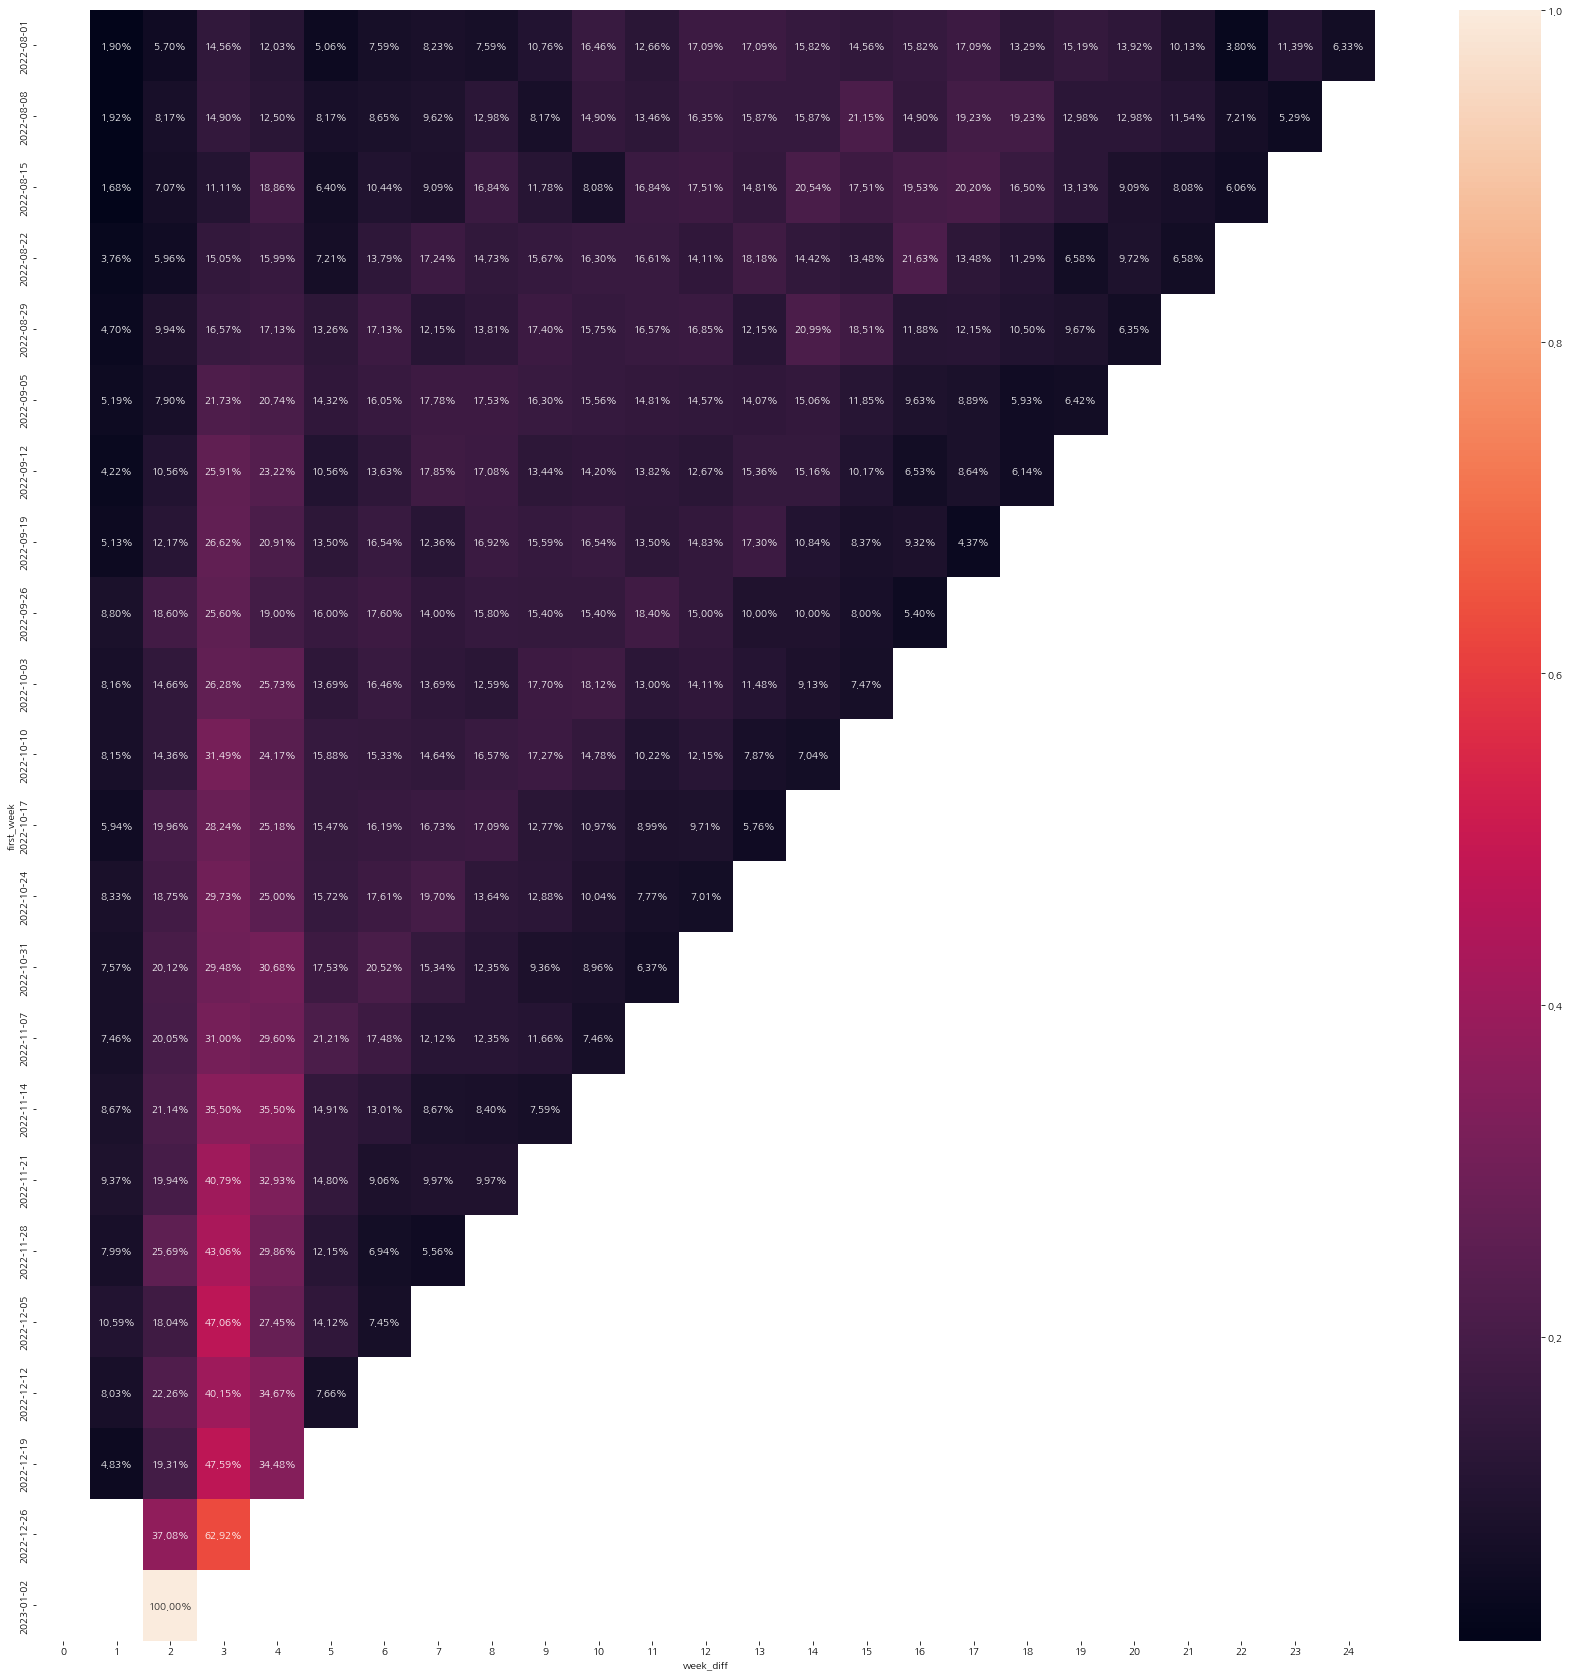

In [246]:
# 연휴 주차와 아닌 주차를 중심적으로 비교해보자

plt.figure(figsize=(30,30))

# 코호트 피봇 테이블에서 의미 없는 부분 (아래 절반 삼각형, 유입주차)
cohort_drop = cohort_mid_pivot.isnull()
cohort_drop.iloc[:,0] = True

sns.heatmap(
    data = cohort_mid_pivot,
    mask = cohort_drop,
    annot = True,
    fmt=".2%"
)

#### 장기 재방문 유저

In [247]:
sql = f"""
/* 장기 재방문 유저의 코호트 리텐션 계산 */

WITH long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
    SELECT
        event_datetime,
        event_date,
        event_time,
        event_week,
        event_dow,
        user_pseudo_id,
        user_id,
        firebase_screen,
        event_name,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
        SELECT user_pseudo_id
        FROM advanced.app_logs_target_visit_seg
        WHERE visit_interval_cat = 'long'
    )
)
, week_diff_long AS (
    -- 2) 사용자별 유입주차, 방문주차, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_week,
        event_week,
        DATE_DIFF(event_week, first_week, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_week) OVER (PARTITION BY user_pseudo_id) AS first_week,
        event_week,
    FROM long_user_logs
    )
)
, week_retain_long AS (
    -- 3) 유입주차, 방문간격(주차)별 유저 수 카운팅
    SELECT
        first_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_long
    GROUP BY first_week, week_diff
)


-- 코호트 리텐션 계산
SELECT
    first_week,
    week_diff,
    retain_users,
    first_users,
    SAFE_DIVIDE(retain_users,first_users) AS retention_rate
FROM (
    SELECT
        first_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY first_week ORDER BY week_diff) AS first_users
    FROM week_retain_long
)
"""

query_job = client.query(sql)
df_cohort_long = query_job.to_dataframe()
df_cohort_long.head()

,first_week,week_diff,retain_users,first_users,retention_rate
0,2022-08-01,0,735,735,1.000000
1,2022-08-01,1,17,735,0.023129
2,2022-08-01,2,20,735,0.027211
3,2022-08-01,3,21,735,0.028571
4,2022-08-01,4,24,735,0.032653


In [248]:
# 피봇 테이블 먼저 만들어주기
import pandas as pd

cohort_long_pivot = pd.pivot_table(
    data = df_cohort_long,
    index = 'first_week',
    columns = 'week_diff',
    values = 'retention_rate'
)

cohort_long_pivot

week_diff,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
first_week,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1.0,0.023129,0.027211,0.028571,0.032653,0.050340,0.076190,0.077551,0.058503,0.104762,...,0.082993,0.104762,0.099320,0.088435,0.103401,0.102041,0.089796,0.106122,0.119728,0.107483
2022-08-08,1.0,0.028714,0.031211,0.023720,0.043695,0.083645,0.072409,0.071161,0.083645,0.138577,...,0.113608,0.102372,0.097378,0.101124,0.097378,0.101124,0.093633,0.119850,0.086142,NaN
2022-08-15,1.0,0.029386,0.032057,0.037400,0.054319,0.056990,0.066785,0.103295,0.112199,0.112199,...,0.072128,0.121104,0.109528,0.096171,0.100623,0.111309,0.118433,0.073909,NaN,NaN
2022-08-22,1.0,0.042068,0.039439,0.029798,0.032428,0.086766,0.102542,0.127958,0.107800,0.100789,...,0.098160,0.111306,0.095530,0.107800,0.095530,0.129711,0.082384,NaN,NaN,NaN
2022-08-29,1.0,0.037885,0.047356,0.039463,0.056038,0.097080,0.132597,0.107340,0.097080,0.140489,...,0.116811,0.117601,0.116022,0.101026,0.131807,0.093923,NaN,NaN,NaN,NaN
2022-09-05,1.0,0.053864,0.042935,0.046058,0.064793,0.138173,0.116315,0.099141,0.113973,0.085090,...,0.096799,0.085090,0.128025,0.122560,0.100703,NaN,NaN,NaN,NaN,NaN
2022-09-12,1.0,0.047841,0.052492,0.071761,0.093688,0.119601,0.099668,0.122259,0.106312,0.106312,...,0.119601,0.111628,0.119601,0.093023,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-19,1.0,0.048336,0.057845,0.070523,0.064976,0.130745,0.125198,0.103803,0.099049,0.095087,...,0.110935,0.127575,0.101426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-26,1.0,0.073896,0.086747,0.060241,0.079518,0.134137,0.113253,0.107631,0.110040,0.105221,...,0.137349,0.114056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='week_diff', ylabel='first_week'>

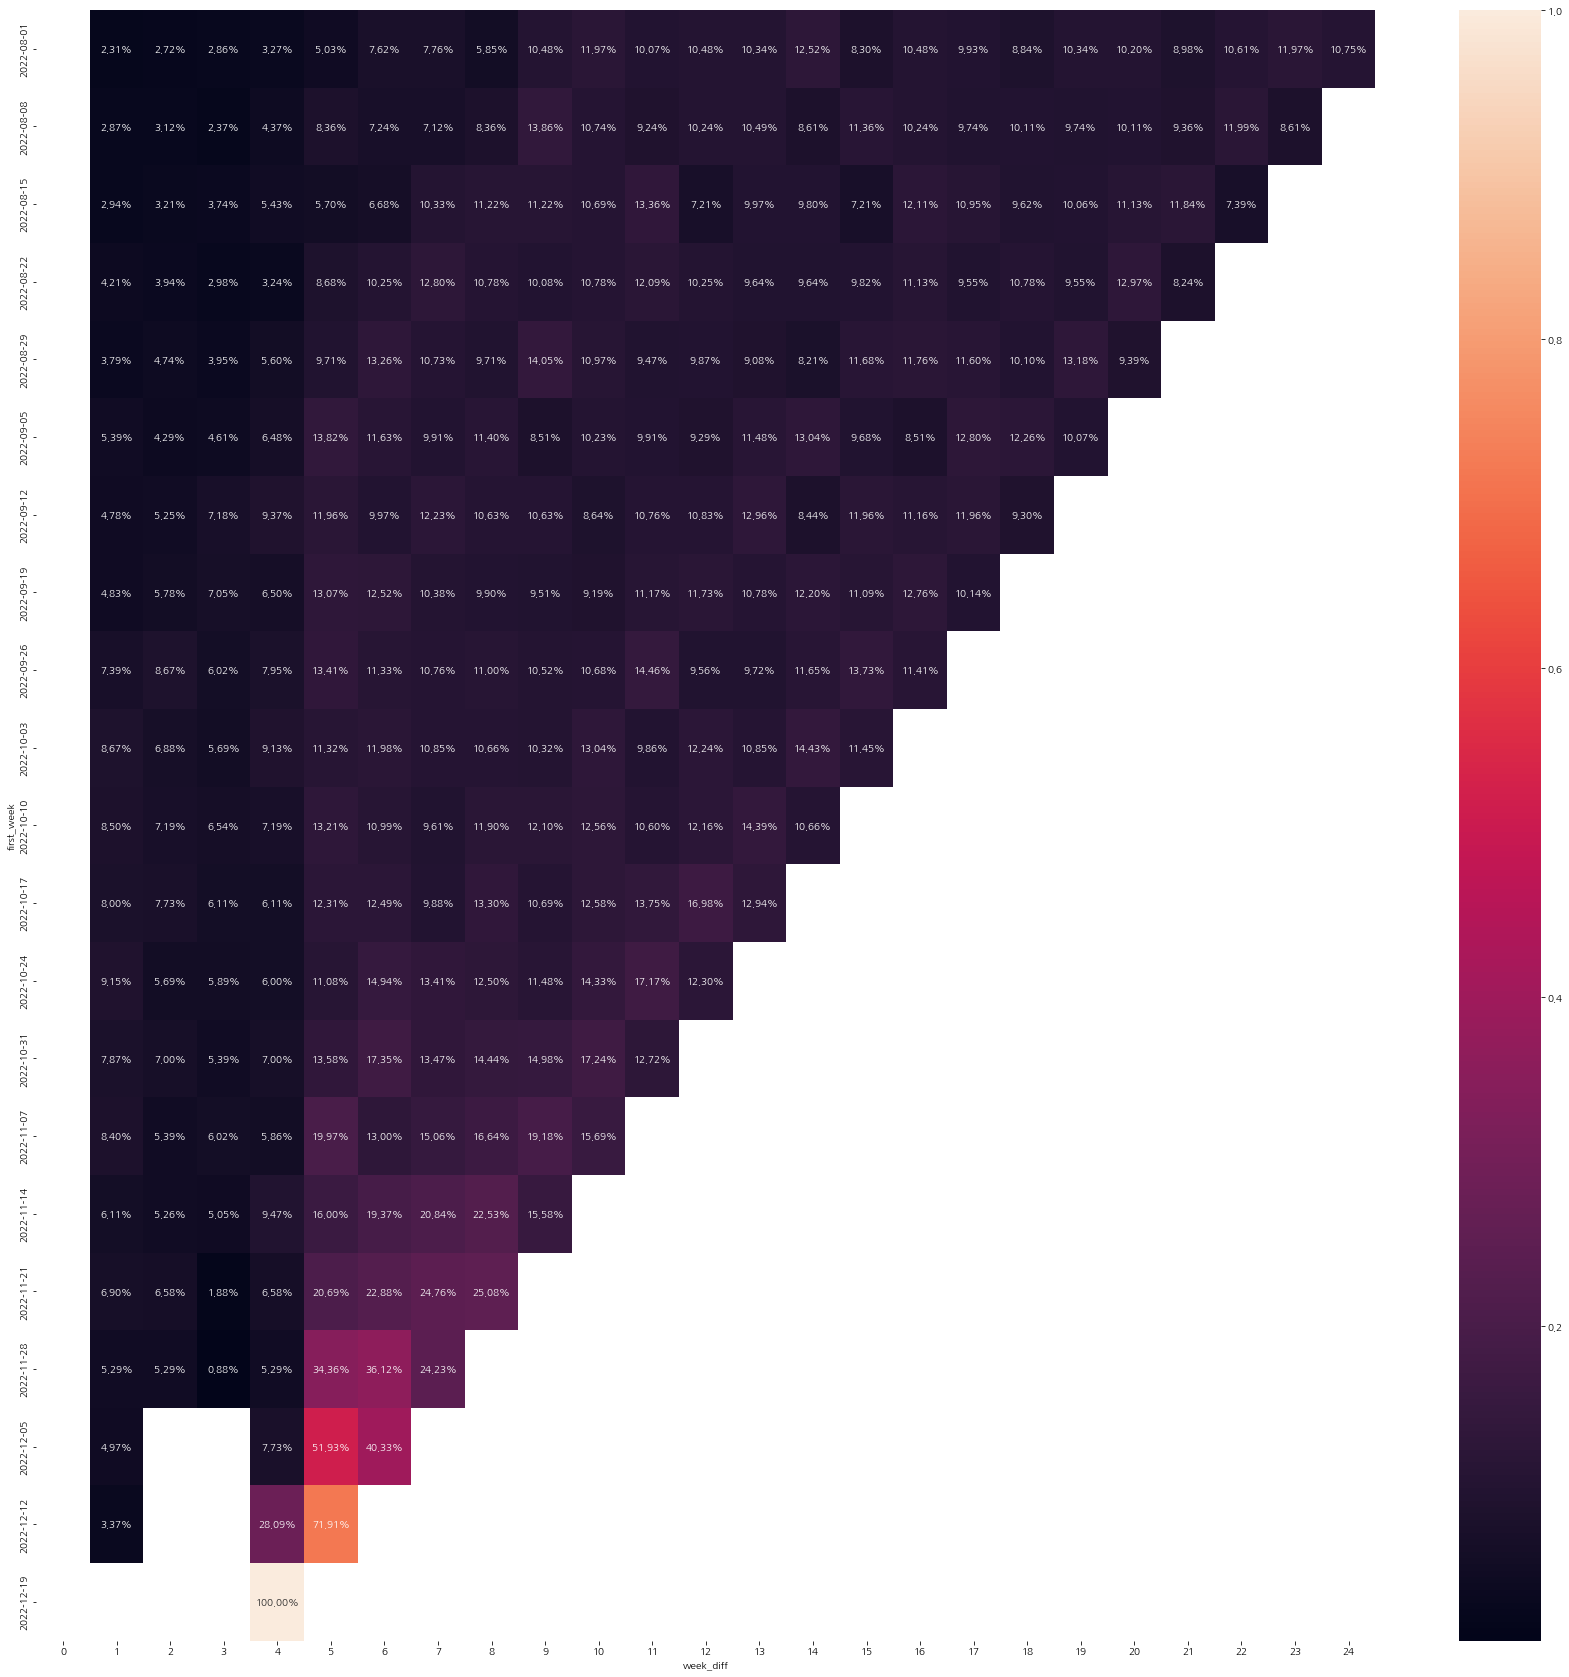

In [249]:
# 연휴 주차와 아닌 주차를 중심적으로 비교해보자

plt.figure(figsize=(30,30))

# 코호트 피봇 테이블에서 의미 없는 부분 (아래 절반 삼각형, 유입주차)
cohort_drop = cohort_long_pivot.isnull()
cohort_drop.iloc[:,0] = True

sns.heatmap(
    data = cohort_long_pivot,
    mask = cohort_drop,
    annot = True,
    fmt=".2%"
)

### 주차별 주문 퍼널 전환율 추이

In [ ]:
sql = f"""
/* 주차별 주문 퍼널 구하기 */
WITH base AS (
  -- 전체 세션 리스트 
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) AS event_date,
    TIMESTAMP_MICROS(event_timestamp) AS event_datetime,
    user_pseudo_id,
    user_id,
    event_name, 
    MAX(IF(params.key='firebase_screen', params.value.string_value, NULL)) AS `firebase_screen`, 
    MAX(IF(params.key='session_id', params.value.string_value, NULL)) AS `session_id`,
    -- platform,
  FROM advanced.app_logs
  CROSS JOIN UNNEST(event_params) AS params
  GROUP BY ALL
)
, base_filtered AS (
  SELECT
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS event_week,
    event_date,
    event_datetime,
    user_pseudo_id,
    CONCAT(firebase_screen, ': ', event_name) AS screen_event
  FROM base
  WHERE 1=1
  AND event_name IN ('click_payment','screen_view')
  AND firebase_screen IN ('welcome','home','food_category','restaurant','food_detail','cart')
)
, funnel_origin AS (
  SELECT
    event_week,
    screen_event,
    CASE WHEN screen_event='welcome: screen_view' THEN 1
        WHEN screen_event='home: screen_view' THEN 2
        WHEN screen_event='food_category: screen_view' THEN 3
        WHEN screen_event='restaurant: screen_view' THEN 4
        WHEN screen_event='food_detail: screen_view' THEN 5
        WHEN screen_event='cart: screen_view' THEN 6
        WHEN screen_event='cart: click_payment' THEN 7
        ELSE 0
    END AS funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS user_cnt
  FROM base_filtered
  GROUP BY ALL
)
, wau_list AS (
  -- 주차별로 퍼널과 WAU를 대조하기 위함.
  SELECT
    DATE_TRUNC(EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)), WEEK(MONDAY)) AS event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs
  GROUP BY DATE_TRUNC(EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)), WEEK(MONDAY))
)


-- 주차별 주문 퍼널 전환율/이탈율 계산
-- 22-07-25 주차의 경우 click_payment 이벤트가 발생하지 않음.
SELECT
  f.event_week,
  f.screen_event,
  f.funnel_step,
  f.user_cnt,
  w.wau,
  ROUND(SAFE_DIVIDE(f.user_cnt, w.wau)*100, 3) AS convertion_rate,  -- 전환율
  ROUND((1-SAFE_DIVIDE(f.user_cnt, w.wau))*100, 3) AS churn_rate  -- 이탈율 (=1-전환률)
FROM funnel_origin f
CROSS JOIN wau_list w
WHERE 1=1
AND f.event_week = w.event_week
AND f.event_week != '2022-07-25'
ORDER BY event_week, funnel_step
"""

query_job = client.query(sql)
df_week = query_job.to_dataframe()
df_week.head()

,event_week,screen_event,funnel_step,user_cnt,wau,convertion_rate,churn_rate
0,2022-08-01,welcome: screen_view,1,1211,1211,100.000,0.000
1,2022-08-01,home: screen_view,2,1023,1211,84.476,15.524
2,2022-08-01,food_category: screen_view,3,430,1211,35.508,64.492
3,2022-08-01,restaurant: screen_view,4,373,1211,30.801,69.199
4,2022-08-01,food_detail: screen_view,5,233,1211,19.240,80.760


In [ ]:
funnel_cnt = df_week['funnel_step'].unique()

for i in range(1,len(funnel_cnt)+1):
    globals()['df_week_funnel_{}'.format(i)] = df_week.loc[df_week['funnel_step']==i]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_week_funnel_2['event_week'],
                         y=df_week_funnel_2['convertion_rate'],
                         name='step 1→2'
))
fig.add_trace(go.Scatter(x=df_week_funnel_3['event_week'],
                         y=df_week_funnel_3['convertion_rate'],
                         name='step 2→3'
))
fig.add_trace(go.Scatter(x=df_week_funnel_4['event_week'],
                         y=df_week_funnel_4['convertion_rate'],
                         name='step 3→4'
))
fig.add_trace(go.Scatter(x=df_week_funnel_5['event_week'],
                         y=df_week_funnel_5['convertion_rate'],
                         name='step 4→5'
))
fig.add_trace(go.Scatter(x=df_week_funnel_6['event_week'],
                         y=df_week_funnel_6['convertion_rate'],
                         name='step 5→6'
))
fig.add_trace(go.Scatter(x=df_week_funnel_7['event_week'],
                         y=df_week_funnel_7['convertion_rate'],
                         name='step 6→7'
))

fig.update_layout(title_text="주차별 주문 퍼널 전환률 추이")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='전환율(%)')

fig.show()